# Discovery of prime integrals with dCGP

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over vectorized floats

In [1]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint, random
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

We consider a set of differential equations in the form:
$$\left\{
\begin{array}{c}
\frac{dx_1}{dt} = f_1(x_1, \cdots, x_n) \\
\vdots \\
\frac{dx_n}{dt} = f_n(x_1, \cdots, x_n)
\end{array}\right.
$$
and we search for expressions $P(x_1, \cdots, x_n) = 0$ which we call prime integrals of motion.

The straight forward approach to design such a search would be to represent $P$ via a $dCGP$ program and evolve its chromosome so that the expression, computed along points of some trajectory, evaluates to zero. This naive approach brings to the evolution of trivial programs that are identically zero and that "do not represent the intrinsic reltations between state varaibles" - Schmidt 2009. 

Let us, though, differentiate $P$ along a trajectory solution to the ODEs above. We get:
$$
\frac{dP}{dt} = \sum_{i=0}^n \frac{\partial P}{\partial x_i} \frac{dx_i}{dt} = \sum_{i=0}^n \frac{\partial P}{\partial x_i} f_i = 0
$$
we may try to evolve the expression $P$ so that the above relation is satisfied on chosen points (belonging to a real trajectory or just defined on a grid). To avoid evolution to go towards trivial solutions, unlike Schmidt, we suppress all mutations that give raise to expressions for which $\sum_{i=0}^n \left(\frac{\partial P}{\partial x_i}\right)^2 = 0$. That is, expressions that do not depend on the state.

### A mass spring system

As a simple example, consider the following mass-spring system. 

The ODEs are:
$$\left\{
\begin{array}{l}
\dot v = -kx \\
\dot x = v
\end{array}\right.
$$

We define a dCGP having three inputs (the state and the constant $k$) and one output ($P$)

In [2]:
kernels = kernel_set(["sum", "mul", "pdiv", "diff"])() # note the call operator (returns the list of kernels)
dCGP = expression(inputs=3, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))

We define 50 random control of points where we check that the prime integral holds: $x \in [2,4]$, $v \in [2,4]$ and $k \in[2, 4]$

In [3]:
n_points = 50
x = []
v = []
k = []
for i in range(n_points):
    x.append(random()*2 + 2)
    v.append(random()*2 + 2)
    k.append(random()*2 + 2)
x = gdual(x,"x",1)
v = gdual(v,"v",1)
k = gdual(k)


In [4]:
def fitness_call(dCGP, x, v, k):
    res = dCGP([x,v,k])[0]
    dPdx = np.array(res.get_derivative({"dx": 1}))
    dPdv = np.array(res.get_derivative({"dv": 1}))
    xcoeff = np.array(x.constant_cf)
    vcoeff = np.array(v.constant_cf)
    kcoeff = np.array(k.constant_cf)
    err = dPdx/dPdv - kcoeff * xcoeff / vcoeff
    return sum(err * err), 3
    
    

In [5]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, dCGP, x, v, k, screen_output=False):
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = 1e10
        
    for g in range(max_gen):
        for i in range(offsprings):
            check = 0
            while(check < 1e-3):
                dCGP.set(best_chromosome)
                dCGP.mutate_active(i+1) #  we mutate a number of increasingly higher active genes
                fitness[i], check = fitness_call(dCGP, x,v,k)
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    dCGP.set(chromosome[i])
                    print("New best found: gen: ", g, " value: ", fitness[i], " ", dCGP.simplify(["x","v","k"]))
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
        if best_fitness < 1e-12:
            break
    dCGP.set(best_chromosome)
    return g, dCGP


In [6]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 2000
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=3, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))
    g, dCGP = run_experiment(stop, 10, dCGP, x,v,k, False)
    res.append(g)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","v","k"]), " a.k.a ", dCGP.simplify(["x","v","k"]))
        one_sol = dCGP
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 1221 	 ['(((k-k)+x)*(((v/k)/(x/((v/k)*k)))+((k-k)+x)))']  a.k.a  [x**2 + v**2/k]
3 		 557 	 ['((v*v)+((x*k)*x))']  a.k.a  [k*x**2 + v**2]
5 		 382 	 ['(((x*k)+((((v-x)/x)*v)+v))/(((v-x)/x)/(v-x)))']  a.k.a  [k*x**2 + v**2]
8 		 1249 	 ['((((k/v)+v)/(k/v))+(x*x))']  a.k.a  [x**2 + 1 + v**2/k]
10 		 9 	 ['((v*v)+(k*(x*x)))']  a.k.a  [k*x**2 + v**2]
14 		 198 	 ['(((k-(k*x))*x)-((v*v)+(k*x)))']  a.k.a  [-k*x**2 - v**2]
15 		 1281 	 ['(((k*x)/k)*((v/(x/v))+(k*x)))']  a.k.a  [k*x**2 + v**2]
21 		 1595 	 ['(((k*x)*(((k/(k*x))*k)+x))+(v*v))']  a.k.a  [k**2 + k*x**2 + v**2]
23 		 321 	 ['(((x*x)+v)-(((x*x)+((x*x)+v))+((v*v)/k)))']  a.k.a  [-x**2 - v**2/k]
24 		 1804 	 ['((k/(x*k))/((v/(x/v))+(x*k)))']  a.k.a  [1/(k*x**2 + v**2)]
31 		 1292 	 ['((v*v)+(k+(x*(k*x))))']  a.k.a  [k*x**2 + k + v**2]
34 		 417 	 ['((k-v)/(((v/(k/v))+(x*x))*(k-v)))']  a.k.a  [1/(x**2 + v**2/k)]
42 		 880 	 ['(((((x*k)-((v*v)/x))-(x*k))-(((x*k)*((v*v)/(v*v)))*((v*v)/(v*v))))*((x*k)*(

In [7]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)


ERT Expected run time - avg. number of function evaluations needed:  49888.1818182


[k**2*x**2 + k*v**2]


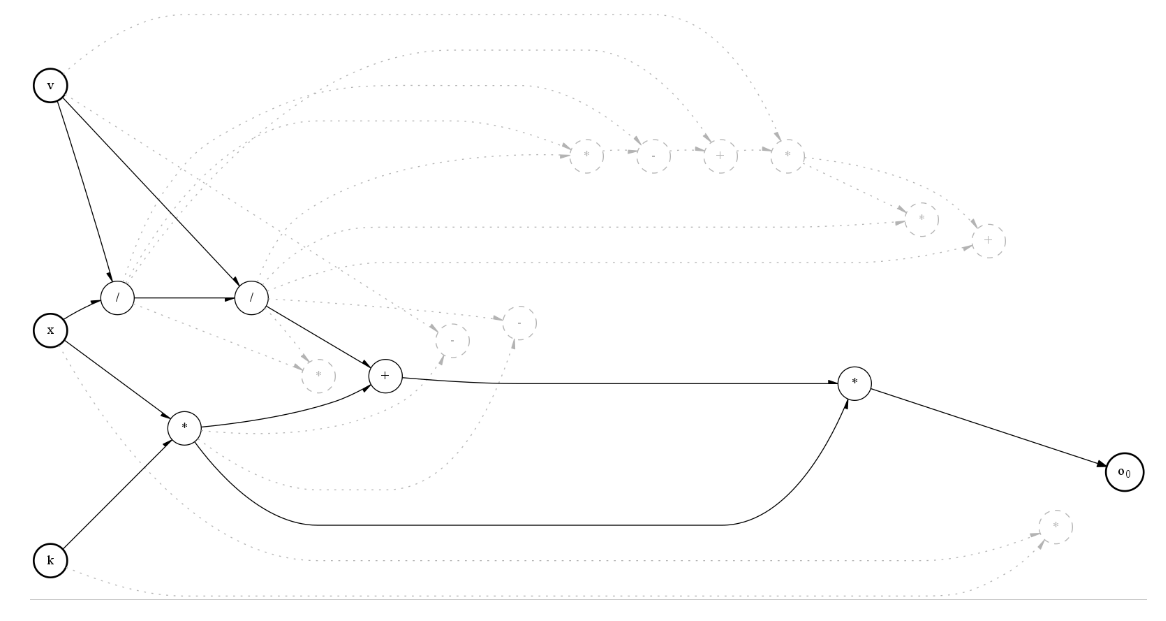

In [8]:
print(one_sol.simplify(["x","v","k"]))
plt.rcParams["figure.figsize"] = [20,20]
one_sol.visualize(["x","v","k"])

### Simple pendulum

Consider the simple pendulum problem. In particular its differential formulation:

The ODEs are:
$$\left\{
\begin{array}{l}
\dot \omega = - \frac gL\sin\theta \\
\dot \theta = \omega \\
\end{array}\right.
$$

We define a dCGP having three inputs (the state and the constant $\frac gL$) and one output ($P$)

In [9]:
kernels = kernel_set(["sum", "mul", "pdiv", "diff","sin","cos"])() # note the call operator (returns the list of kernels)
dCGP = expression(inputs=3, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))

We define 50 random control of points where we check that the prime integral holds: $\omega \in [-1, 1]$, $\theta \in [-1, 1]$, and $\frac gL \in [1,2]$

In [10]:
n_points = 50
omega = []
theta = []
c = []
for i in range(n_points):
    omega.append(random()*10 - 5)
    theta.append(random()*10 - 5)
    c.append(random()*10)
    
omega = gdual(omega,"omega",1)
theta = gdual(theta,"theta",1)
c = gdual(c)



In [11]:
def fitness_call(dCGP, theta, omega, c):
    res = dCGP([theta, omega, c])[0]
    dPdtheta = np.array(res.get_derivative({"dtheta": 1}))
    dPdomega = np.array(res.get_derivative({"domega": 1}))
    thetacoeff = np.array(theta.constant_cf)
    omegacoeff = np.array(omega.constant_cf)
    ccoeff = np.array(c.constant_cf)
    err = dPdtheta/dPdomega + (-ccoeff * np.sin(thetacoeff)) / omegacoeff
    check = sum(dPdtheta*dPdtheta + dPdomega*dPdomega)
    return sum(err * err ), check

In [12]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, dCGP,  theta, omega, c, screen_output=False):
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = 1e10
        
    for g in range(max_gen):
        for i in range(offsprings):
            check = 0
            while(check < 1e-3):
                dCGP.set(best_chromosome)
                dCGP.mutate_active(i+1) #  we mutate a number of increasingly higher active genes
                fitness[i], check = fitness_call(dCGP, theta, omega, c)
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    dCGP.set(chromosome[i])
                    print("New best found: gen: ", g, " value: ", fitness[i], " ", dCGP.simplify(["theta","omega","c"]))
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
        if best_fitness < 1e-12:
            break
    dCGP.set(best_chromosome)
    return g, dCGP


In [13]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 2000
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=3, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))
    g, dCGP = run_experiment(stop, 10, dCGP, theta, omega, c, False)
    res.append(g)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["theta","omega","c"]), " a.k.a ", dCGP.simplify(["theta","omega","c"]))
        one_sol = dCGP
res = np.array(res)

restart: 	 gen: 	 expression:
5 		 1087 	 ['(((c*cos(theta))+(c*cos(theta)))-(omega*omega))']  a.k.a  [2*c*cos(theta) - omega**2]
9 		 1007 	 ['(((((omega*omega)/c)-cos(theta))-cos(theta))/c)']  a.k.a  [-2*cos(theta)/c + omega**2/c**2]
11 		 727 	 ['(((cos(theta)-((omega*omega)/c))+cos(theta))-((omega*omega)/((omega*omega)/c)))']  a.k.a  [-c + 2*cos(theta) - omega**2/c]
17 		 509 	 ['(cos(((theta-theta)+(theta+(theta-theta))))-(((omega*omega)-(theta-theta))/(c+c)))']  a.k.a  [cos(theta) - omega**2/(2*c)]
19 		 1780 	 ['(sin(((omega*omega)/((omega*omega)/c)))*((cos(theta)-((omega*omega)/c))+cos(theta)))']  a.k.a  [2*sin(c)*cos(theta) - omega**2*sin(c)/c]
31 		 246 	 ['(cos(theta)-(((omega*omega)/c)-cos(theta)))']  a.k.a  [2*cos(theta) - omega**2/c]
34 		 154 	 ['(((c*cos(theta))+(cos(theta)*c))-(omega*omega))']  a.k.a  [2*c*cos(theta) - omega**2]
38 		 506 	 ['((cos(theta)*c)-(((omega*omega)+c)-(cos(theta)*c)))']  a.k.a  [2*c*cos(theta) - c - omega**2]
54 		 1063 	 ['((((c+c)*cos(theta)

In [14]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)

ERT Expected run time - avg. number of function evaluations needed:  114250.625


[-cos(theta) + omega**2/(2*c)]


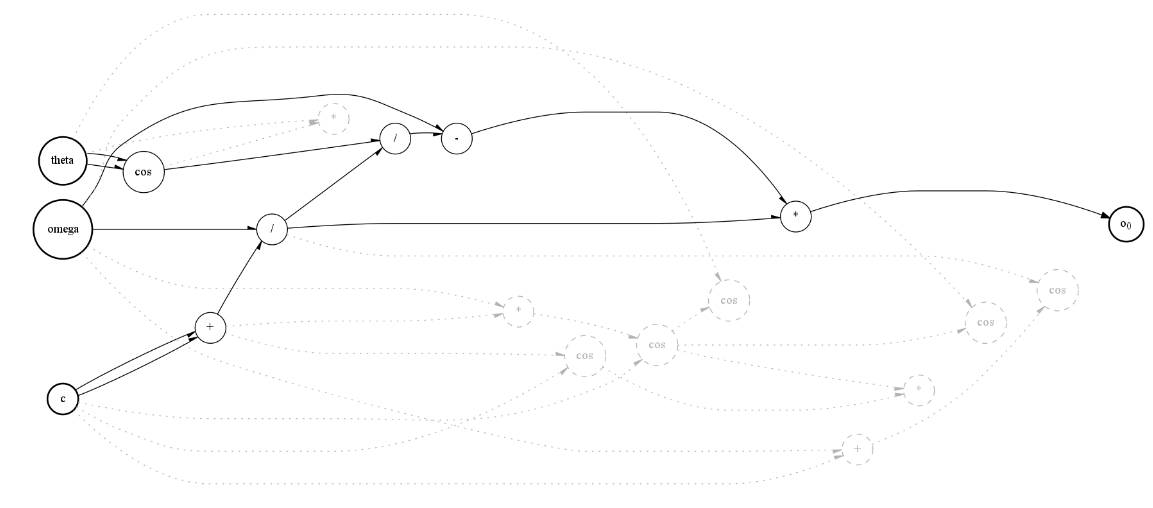

In [15]:
print(one_sol.simplify(["theta","omega","c"]))
plt.rcParams["figure.figsize"] = [20,20]
one_sol.visualize(["theta","omega","c"])

### The two-body problem

Consider the two body problem. In particular its differential formulation in polar coordinates:

The ODEs are:
$$\left\{
\begin{array}{l}
\dot v = -\frac\mu{r^2} + r\omega^2 \\
\dot \omega = - 2 \frac{v\omega}{r} \\
\dot r = v \\
\dot \theta = \omega
\end{array}\right.
$$

We define a dCGP having five inputs (the state and the constant $\mu$) and one output ($P$)

In [16]:
kernels = kernel_set(["sum", "mul", "pdiv", "diff"])() # note the call operator (returns the list of kernels)
dCGP = expression(inputs=3, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))

We define 50 random control of points where we check that the prime integral holds: $r \in [0.1,1.1]$, $v \in [2,4]$, $\omega \in [1,2]$ and $\theta \in[2, 4]$ and $\mu \in [1,2]$

In [17]:
n_points = 50
v = []
omega = []
r = []
theta = []
mu = []
for i in range(n_points):
    v.append(random()*2 + 2)
    omega.append(random()*1 + 1)
    r.append(random() + 0.1)
    theta.append(random()*2 + 2)
    mu.append(random() + 1)
    
r = gdual(r,"r",1)
omega = gdual(omega,"omega",1)
v = gdual(v,"v",1)
theta = gdual(theta,"theta",1)
mu = gdual(mu)



In [18]:
## Use this fitness if energy conservation is to be found (it basically forces the expression to depend on v)
def fitness_call(dCGP, r, v, theta, omega, mu):
    res = dCGP([r, v, theta, omega, mu])[0]
    dPdr = np.array(res.get_derivative({"dr": 1}))
    dPdv = np.array(res.get_derivative({"dv": 1}))
    dPdtheta = np.array(res.get_derivative({"dtheta": 1}))
    dPdomega = np.array(res.get_derivative({"domega": 1}))
    rcoeff = np.array(r.constant_cf)
    vcoeff = np.array(v.constant_cf)
    thetacoeff = np.array(theta.constant_cf)
    omegacoeff = np.array(omega.constant_cf)
    mucoeff = np.array(mu.constant_cf)
    err = dPdr / dPdv +  (-mucoeff/rcoeff**2 + rcoeff*omegacoeff**2) / vcoeff + dPdtheta / dPdv  / vcoeff * omegacoeff + dPdomega / dPdv  / vcoeff * (-2*vcoeff*omegacoeff/rcoeff)
    check = sum(dPdr*dPdr + dPdv*dPdv + dPdomega*dPdomega + dPdtheta*dPdtheta)
    return sum(err * err), check

## Use this fitness if any conservation is to be found (will always converge to angular momentum)
def fitness_call_free(dCGP, r, v, theta, omega, mu):
    res = dCGP([r, v, theta, omega, mu])[0]
    dPdr = np.array(res.get_derivative({"dr": 1}))
    dPdv = np.array(res.get_derivative({"dv": 1}))
    dPdtheta = np.array(res.get_derivative({"dtheta": 1}))
    dPdomega = np.array(res.get_derivative({"domega": 1}))
    rcoeff = np.array(r.constant_cf)
    vcoeff = np.array(v.constant_cf)
    thetacoeff = np.array(theta.constant_cf)
    omegacoeff = np.array(omega.constant_cf)
    mucoeff = np.array(mu.constant_cf)
    err = dPdr * vcoeff +  dPdv * (-mucoeff/rcoeff**2 + rcoeff*omegacoeff**2) + dPdtheta * omegacoeff + dPdomega * (-2*vcoeff*omegacoeff/rcoeff)
    check = sum(dPdr*dPdr + dPdv*dPdv +dPdomega*dPdomega+ dPdtheta*dPdtheta)
    return sum(err * err ), check

In [19]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, dCGP,  r, v, theta, omega, mu, obj_fun, screen_output=False):
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = 1e10
        
    for g in range(max_gen):
        for i in range(offsprings):
            check = 0
            while(check < 1e-3):
                dCGP.set(best_chromosome)
                dCGP.mutate_active(i+1) #  we mutate a number of increasingly higher active genes
                fitness[i], check = obj_fun(dCGP, r, v, theta, omega, mu)
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    dCGP.set(chromosome[i])
                    print("New best found: gen: ", g, " value: ", fitness[i], " ", dCGP.simplify(["r","v","theta","omega","mu"]))
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
        if best_fitness < 1e-12:
            break
    dCGP.set(best_chromosome)
    return g, dCGP


In [20]:
# We run nexp experiments to accumulate statistic for the ERT (angular momentum case)
nexp = 100
offsprings = 10
stop = 2000 #100000
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=5, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))
    g, dCGP = run_experiment(stop, 10, dCGP, r, v, theta, omega, mu, fitness_call_free, False)
    res.append(g)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["r","v","theta","omega","mu"]), " a.k.a ", dCGP.simplify(["r","v","theta","omega","mu"]))
        one_sol = dCGP
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 117 	 ['((r+r)/((r+r)+((mu/omega)/(r+r))))']  a.k.a  [2*r/(mu/(2*omega*r) + 2*r)]
1 		 76 	 ['((omega*r)*r)']  a.k.a  [omega*r**2]
2 		 421 	 ['((mu+theta)/((((mu+theta)*(theta-(mu+theta)))*r)*(r*omega)))']  a.k.a  [-1/(mu*omega*r**2)]
3 		 22 	 ['((omega*((theta*(theta-theta))-r))*((theta*(theta-theta))-r))']  a.k.a  [omega*r**2]
4 		 634 	 ['(((omega/omega)/(mu+((r*omega)*r)))/(omega/omega))']  a.k.a  [1/(mu + omega*r**2)]
5 		 408 	 ['((r*(omega*r))/(theta/theta))']  a.k.a  [omega*r**2]
6 		 533 	 ['(mu-((r*omega)*(r/mu)))']  a.k.a  [mu - omega*r**2/mu]
7 		 73 	 ['((omega/((r/mu)*omega))/((r/mu)*omega))']  a.k.a  [mu**2/(omega*r**2)]
8 		 1573 	 ['((r*(mu*omega))*(v-(r+v)))']  a.k.a  [-mu*omega*r**2]
9 		 196 	 ['((((r/theta)*theta)/(mu*(theta/v)))*((omega*(mu*(theta/v)))*r))']  a.k.a  [omega*r**2]
10 		 21 	 ['(omega*(r*r))']  a.k.a  [omega*r**2]
12 		 316 	 ['((r*(omega/v))*(v*r))']  a.k.a  [omega*r**2]
14 		 6 	 ['(((r*r)*omega)/mu)']  a.k.a  [

In [21]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)

ERT Expected run time - avg. number of function evaluations needed:  5270.98901099


[2*omega*r**2/mu]


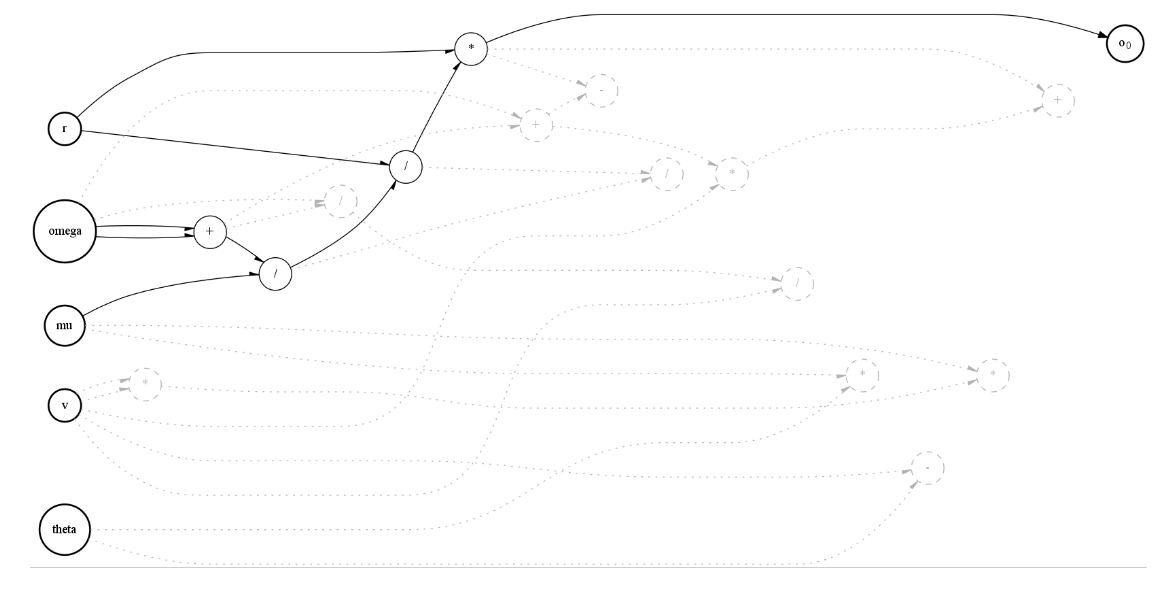

In [22]:
print(one_sol.simplify(["r","v","theta","omega","mu"]))
plt.rcParams["figure.figsize"] = [20,20]
one_sol.visualize(["r","v","theta","omega","mu"])

In [23]:
# We run nexp experiments to accumulate statistic for the ERT (angular momentum case)
nexp = 100
offsprings = 10
stop = 100000
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=5, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,234213213))
    g, dCGP = run_experiment(stop, 10, dCGP, r, v, theta, omega, mu, fitness_call, False)
    res.append(g)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["r","v","theta","omega","mu"]), " a.k.a ", dCGP.simplify(["r","v","theta","omega","mu"]))
        one_sol = dCGP
res = np.array(res)

restart: 	 gen: 	 expression:
2 		 25413 	 ['(((v-r)*(v+r))-((((mu-r)+(mu-r))/r)-((r-(r*omega))*(r-(r*omega)))))']  a.k.a  [-2*mu/r + omega**2*r**2 - 2*omega*r**2 + v**2 + 2]
3 		 46221 	 ['((v*(v*(mu+mu)))-((((mu+mu)*(mu+mu))/((r*r)/r))-(((omega*omega)*(r*r))*(mu+mu))))']  a.k.a  [-4*mu**2/r + 2*mu*omega**2*r**2 + 2*mu*v**2]
6 		 97122 	 ['(((((v*(v*r))-mu)+(((omega*r)*(r*(omega*r)))-mu))*(omega*r))*mu)']  a.k.a  [-2*mu**2*omega*r + mu*omega**3*r**4 + mu*omega*r**2*v**2]
8 		 28010 	 ['(((mu/r)-((v*v)-(mu/r)))-((r*omega)*(r*omega)))']  a.k.a  [2*mu/r - omega**2*r**2 - v**2]
16 		 22942 	 ['(((omega*r)*((mu/(mu/r))+(omega*r)))+(mu-((mu/r)+((mu/r)-(v*v)))))']  a.k.a  [mu - 2*mu/r + omega**2*r**2 + omega*r**2 + v**2]
28 		 63318 	 ['(((((mu/r)+mu)-((omega*r)*(omega*r)))+(((mu/r)+mu)-(v*v)))+((((mu/r)+mu)-((omega*r)*(omega*r)))+(((mu/r)+mu)-(v*v))))']  a.k.a  [4*mu + 4*mu/r - 2*omega**2*r**2 - 2*v**2]
36 		 12543 	 ['(((omega*r)*(r-(omega*r)))+((mu/r)-((v*v)-(mu/r))))']  a.k.a  [2*mu/r - 

In [ ]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)